# Recurrent Neural Networks

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tensorflow/05-tensorflow-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

```text
𝗔𝘁𝘁𝗿𝗶𝗯𝘂𝘁𝗶𝗼𝗻: Notes for Chapter 9: Recurrent Neural Networks of (Dive into Deep Learning) d2l.ai.
```

---

## Introduction

Recall that for MLPs we have fixed-length inputs $\mathbf x \in \mathbb R^d$ that is transformed by passing data to a sequence of layers. Similarly, for CNNs we also have fixed-length inputs for images, and sequential feature extraction. The only difference is the operations implemented in the layers (i.e. instead of dense layers, we have convolution blocks). These networks are designed to capture heirarchical structure of input data. In this notebook, we will be interested in **sequential data**. 

So we want a network that can ingest and output sequential data. In particular, we will be interested in Recurrent Neural Networks (**RNN**) which capture the dynamics of sequences by means of **recurrent connections** ({numref}`unfolded-rnn`). This framework allows inputs to be processed in a feed-forward manner with layer weights shared across time steps. Note that this is starting to look familiar. In fact, we can backpropagate through RNNs, although this introduces difficulties in training, motivating modern RNN architectures that we will discuss in the next notebook.

```{margin}
Figure source:<br>
[`d2l.ai/ch9`](https://www.d2l.ai/chapter_recurrent-neural-networks/index.html)
```
```{figure} ../../img/unfolded-rnn.svg
---
width: 80%
name: unfolded-rnn
---
Unrolling an RNN unit with recurrent connections (cyclic edges).
```

One key insight is that while sequential data have variable length, we can model each sequence as having an evolving state which is a fixed-length vector $(\mathbf x_1, \ldots, \mathbf x_T)$ such that $\mathbf x_i \in \mathbb R^d$ for $t = 1, \ldots, T$ where $T \in \mathbb N.$ For example, documents can be modelled as variable length sequences of fixed-length vector representations of words. Medical diagnoses can be interpreted as a sequence of events that represent the state of patients represented as fixed-length vectors. And videos can be easily modeled as varying length sequences of images of fixed size. 

Examples in this notebook will focus mostly on text data since core problems of NLP motivated basic research in RNNs. But methods developed in this domain transfers easily to other application domains.

In [1]:
import re
import os
import random
import warnings
import collections
from pathlib import Path

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import tensorflow as tf
import tensorflow.keras as kr


DATASET_DIR = Path("./data").absolute()

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Sequence modelling

Some datasets consists of a single massive sequence. For example, readings of a single sensor over a period of time, or sales figures over five years. Previously when dealing with vector inputs $\mathbf x \in \mathbb R^d$, we assumed $\mathbf x \sim p$ where $p$ is an underlying distribution. We will still assume that entire sequences in a dataset are sampled independently and identically. That is, we will assume that documents in a corpus are generated by the same random process. But, of course, we cannot assume that a word $\mathbf x_t$ is independent of the previous word $\mathbf x_{t-1}$ in a document. This is why we expect the beginning of a sentence to be different from its end.

Regarding outputs, we sometimes want to model a single target $y$ given a sequence as input (e.g. sentiment analysis). We may also want to predict a sequence of targets $(y_1, \ldots, y_T)$ given an input (e.g. image captioning). But the length of the output sequence can also differ from the input sequence (e.g. machine translation). As such, outputs can be aligned with 1-1 mapping at each time step, or unaligned where there is no clear step-wise mapping. 

### Density estimation

Before we do supervised learning between sequences, we first consider the problem of unsupervised estimation of the probability mass function given a collection of sequences. That is, we want to estimate the probability of any sequence $p(\mathbf x_1, \ldots, \mathbf x_T).$ This should give us some basic intuitions and statistical tools for dealing with sequence data.

### Autoregressive models

Let us consider the problem of predicting the next value of a real variable, i.e. we want to model $p(x_t \mid x_1, \ldots x_{t-1}).$ Since estimating the continuous distribution of possible values at time $t,$ we can instead model the mean of the distribution $\hat x_t = \mathbb E[x_t \mid (x_1, \ldots, x_{t-1})].$ This can be our estimate which can be modelled, for example, by a linear regression model. Such a model is called an **autoregressive model**. One problem is that for increasing $t,$ the length of the input to the model also increases.



* **Fixed window.** One strategy is to only look at $(x_{t_1}, \ldots, x_{t-\tau})$, i.e. $\tau$ time steps in the past. The immediate benefit is that for $t > \tau$ the input to the model has fixed length. This allows us to train any linear model or deep network that requires fixed-length vectors as inputs. 
<br><br>

* **Latent representation.** Another approach is to have a hidden or latent representation $h_t$ of past states which we use to predict $x_t.$ For example, we can predict $\hat x_t = \mathbb E[x_t \mid h_t]$ such that $h_t = \Upsilon(h_{t-1}, x_{t-1})$ where $\Upsilon$ is some update rule for the hidden state ({numref}`latent-autoregressive`).

```{margin}
Figure source:<br>
[`d2l.ai/ch9`](https://www.d2l.ai/chapter_recurrent-neural-networks/index.html)
```
```{figure} ../../img/latent-autoregressive.png
---
width: 60%
name: latent-autoregressive
---
A latent autoregressive model.
```

### Markov models

Note that by the [chain rule](https://en.wikipedia.org/wiki/Chain_rule_(probability)) we can write the following decomposition where each conditional probability on the right hand side is probability distribution of the next word given the previous context:

$$p(\mathbf x_1, \ldots, \mathbf x_T) = p(\mathbf x_1)\prod_{t=2}^T p\left({\mathbf x}_{t} \mid {\mathbf x}_{t-1}, \ldots, {\mathbf x}_{1}\right).$$

The conditional probabilities can be intractiable, so instead we can use the strategy above of only using past $\tau$ observations. This is called a **Markov condition** where we model future events to be only conditionally dependent on recent events. For example, we can take $\tau = 1$ (first-order Markov model) so that

$$p(\mathbf x_1, \ldots, \mathbf x_T) = p(\mathbf x_1)\prod_{t=2}^T p\left({\mathbf x}_{t} \mid {\mathbf x}_{t-1}\right).$$

This is a way easier problem than above. In this case, the probability of the entire sentence is a product of the probabilities of the next word given the current word multiplied by the probability of the first word. Of course, higher $\tau$ is better but the gain diminishes rapidly so we can tune this to be of a reasonable size. Note that $p\left({\mathbf x}_{t} \mid {\mathbf x}_{t-1} \ldots {\mathbf x}_{t-\tau} \right)$ can be estimated computed by counting relative frequencies.

### Modelling synthetic data

Before we focus our attentions on text data, let’s first try this out with some continuous-valued synthetic data. Our goal is to predict the **next value** of the sequence.

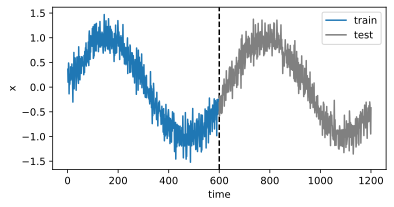

In [2]:
T = 1200
t = np.arange(1, T + 1)
x = np.sin(0.01 * t) + np.random.normal(size=T) * 0.2

noisy_data = pd.DataFrame({'t': t, 'x': x})

cutoff = int(0.50 * T)

plt.figure(figsize=(6, 3))
plt.axvline(x=cutoff, linestyle='dashed', color='black')
plt.plot(noisy_data.query(f't  < {cutoff}').t, noisy_data.query(f't  < {cutoff}').x, label='train')
plt.plot(noisy_data.query(f't >= {cutoff}').t, noisy_data.query(f't >= {cutoff}').x, label='test', color='gray')

plt.legend()
plt.ylabel('x')
plt.xlabel('time');

#### $\tau$-order Markov

To begin, we try a model that acts as though the data satisfied a $\tau$-order Markov condition, and thus predicts $x_{t}$ using only the past $\tau$ observations. For each timestep, we have an example with label $y=x_{t}$ and features $\mathbf{x}_{t}=\left[x_{t-\tau}, \ldots, x_{t-1}\right]$. Data points at $t < \tau$ are simply dropped.

In [3]:
def create_features(data, tau):

    # Create lag features
    X = pd.concat([data[['x']].shift(i) for i in range(tau)], axis=1)
    X.columns = [f'x(t-{i})' if i > 0 else 'x(t)' for i in range(0, tau)]

    # Create target
    X['x(t+1)'] = data[['x']].shift(-1).values
    X['t'] = data.t

    # Rearranging columns: left to right
    cols = ['t'] + [f'x(t-{tau-i})' if i > 0 else 'x(t)' for i in range(1, tau)] + ['x(t)', 'x(t+1)']
    X = X[cols]
    
    return X

Fourth order:

In [4]:
tau = 4
X = create_features(noisy_data, tau=tau)
X

,t,x(t-3),x(t-2),x(t-1),x(t),x(t+1)
0,1,NaN,NaN,NaN,0.362810,0.100030
1,2,NaN,NaN,0.362810,0.100030,0.225743
2,3,NaN,0.362810,0.100030,0.225743,0.488168
3,4,0.362810,0.100030,0.225743,0.488168,0.423491
4,5,0.100030,0.225743,0.488168,0.423491,-0.135492
...,...,...,...,...,...,...
1195,1196,-0.628973,-0.688214,-0.299574,-0.362372,-0.557885
1196,1197,-0.688214,-0.299574,-0.362372,-0.557885,-0.672097
1197,1198,-0.299574,-0.362372,-0.557885,-0.672097,-0.947361
1198,1199,-0.362372,-0.557885,-0.672097,-0.947361,-0.418632


In fact, a larger $\tau$ seems to impact predictions close to the test point negatively.

In [5]:
train = X.query(f't  < {cutoff}').dropna().reset_index(drop=True)
test  = X.query(f't >= {cutoff}').dropna().reset_index(drop=True)

train.head()

,t,x(t-3),x(t-2),x(t-1),x(t),x(t+1)
0,4,0.362810,0.100030,0.225743,0.488168,0.423491
1,5,0.100030,0.225743,0.488168,0.423491,-0.135492
2,6,0.225743,0.488168,0.423491,-0.135492,0.259961
3,7,0.488168,0.423491,-0.135492,0.259961,0.049643
4,8,0.423491,-0.135492,0.259961,0.049643,0.069235


In [6]:
test.head()

,t,x(t-3),x(t-2),x(t-1),x(t),x(t+1)
0,600,-0.402097,-0.341908,-0.475034,-0.315133,-0.579886
1,601,-0.341908,-0.475034,-0.315133,-0.579886,-0.176694
2,602,-0.475034,-0.315133,-0.579886,-0.176694,-0.439363
3,603,-0.315133,-0.579886,-0.176694,-0.439363,-0.193175
4,604,-0.579886,-0.176694,-0.439363,-0.193175,-0.512270


Fit next step prediction model:

In [7]:
model = LinearRegression()
model.fit(train.drop(['t', 'x(t+1)'], axis=1).values, train['x(t+1)'])

LinearRegression()

In [8]:
pred = model.predict(train.drop(['t', 'x(t+1)'], axis=1).values)
print('train rmse:', mean_squared_error(train['x(t+1)'], pred, squared=False))

pred = model.predict(test.drop(['t', 'x(t+1)'], axis=1).values)
print('test  rmse:', mean_squared_error(test['x(t+1)'], pred, squared=False))

train rmse: 0.22638210088979385
test  rmse: 0.21213347239603786


A good test performance is expected since the train and test distributions are identical.

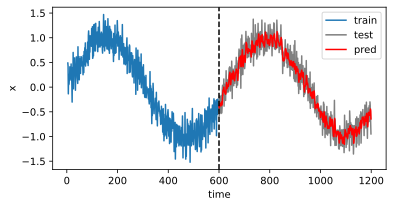

In [9]:
plt.figure(figsize=(6, 3))
plt.plot(train.t, train['x(t)'], zorder=1, label='train')
plt.plot(test.t, test['x(t)'], zorder=1, color='gray', label='test')
plt.plot(test.t, pred, color='red', zorder=2, label='pred')
plt.axvline(x=cutoff, linestyle='dashed', color='black')
plt.xlabel('time')
plt.ylabel('x')
plt.legend();

#### Future steps prediction

Suppose the current time step is $t = 800$ without any knowledge of future time steps. For the fourth-order model above we predicted $\hat{x}_{800}=f\left(x_{796}, x_{797}, x_{798}, x_{799}\right).$ Observe that predicting $k > 1$ time steps into the future doesn't work directly using $f$ because there will be missing data points (i.e. unobserved data points). One thing we can do is to use the model to fill in gaps with predictions:

$$
\begin{aligned}
&f\left(x_{796}, x_{797}, x_{798}, x_{799}\right) = \hat{x}_{800} \\
&f\left(x_{797}, x_{798}, x_{799}, \hat{x}_{800}\right) = \hat{x}_{801}\\
&f\left(x_{798}, x_{799}, \hat{x}_{800}, \hat{x}_{801}\right) = \hat{x}_{802} \\
&f\left(x_{799}, \hat{x}_{800}, \hat{x}_{801}, \hat{x}_{802}\right) = \hat{x}_{803}\\
&f\left(\hat{x}_{800}, \hat{x}_{801}, \hat{x}_{802}, \hat{x}_{803}\right) = \hat{x}_{804}
\end{aligned}
$$

We say that this is $k = 1, 2, 3, 4, 5$ step predictions with $\tau=4.$ Let's check the accuracy of this model. For convenience we will define a class.

In [10]:
class ForecastModel:
    
    def __init__(self, tau, data, cutoff):
        """Pass all known data for 𝜏-order model."""
        self.tau = tau
        self.data = data
        self.model_ = None
        self.features_ = create_features(data, tau).dropna()
        
        # Train next step prediction model below cutoff
        train = self.features_.query(f't < {cutoff}')
        model = LinearRegression()
        model.fit(train.drop(['t', 'x(t+1)'], axis=1).values, train['x(t+1)'])
        self.model_ = model


    def predict(self, t, k=1):
        """Use features x[t-𝜏+1, ..., t] to predict x[t+1], ..., x[t+k]."""

        # Construct features table as in the above equations
        preds = [0] * k
        features = self.features_.query(f't == {t}').drop(['t', 'x(t+1)'], axis=1)
        features = list(features.iloc[0])
        for i in range(k):
            preds[i] = self.model_.predict(np.array(features).reshape(1, -1))[0]
            features = features[1:] + [preds[i]]

        return preds

Predicting $k = 1, 2, \ldots, 200$ from $t = 799$ as described in the above equations with a regression model trained with next step prediction on the time points indicated in the plot. Recall that the above model is able to perform well with a split at $t=600.$ So we can use that.

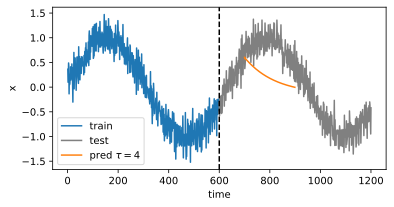

In [11]:
cutoff = 600
train = noisy_data.query(f't  < {cutoff}').dropna().reset_index(drop=True)
test  = noisy_data.query(f't >= {cutoff}').dropna().reset_index(drop=True)

plt.figure(figsize=(6, 3))
plt.plot(train.t, train.x, label='train')
plt.plot(test.t, test.x, label='test', color='gray')
plt.axvline(x=cutoff, linestyle='dashed', color='black')
plt.xlabel('time')
plt.ylabel('x')

# Plot forecasts
t0 = 699
kstep_model = ForecastModel(tau=4, data=noisy_data, cutoff=cutoff)
preds = kstep_model.predict(t=t0, k=200)
plt.plot(
    [t0+k for k in range(1, 200+1)],
    preds, color='C1', zorder=3, label=r'pred $\tau = 4$'
)

plt.legend();

Why did the algorithm perform so much worse? Ultimately, this owes to the fact that errors build up at each prediction step since the model incorporates prediction noise into its features. After a certain point, the predictions become meaningless.

#### Increasing $\tau$

If we look at the evolution of the absolute error, having a larger $\tau$ results in better error rates further into the future. This only works due to the stationary nature of the data. In general, trying to model currently missing features (future values) using a regression model appears to be a bad idea.

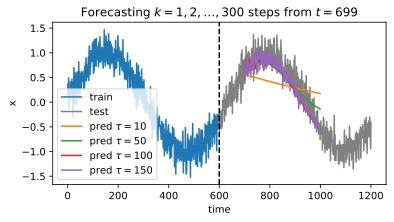

In [12]:
cutoff = 600
train = noisy_data.query(f't  < {cutoff}').dropna().reset_index(drop=True)
test  = noisy_data.query(f't >= {cutoff}').dropna().reset_index(drop=True)

plt.figure(figsize=(6, 3))
plt.plot(train.t, train.x, label='train')
plt.plot(test.t, test.x, label='test', color='gray')
plt.axvline(x=cutoff, linestyle='dashed', color='black')

# Plot forecasts
t0 = 699
tau_range = [10, 50, 100, 150]
for i, tau in enumerate(tau_range):
    kstep_model = ForecastModel(tau=tau, data=noisy_data, cutoff=cutoff)
    preds = kstep_model.predict(t=t0, k=300)
    plt.plot(
        [t0+k for k in range(1, 300+1)],
        preds, color=f'C{i+1}', zorder=3+i, label=r'pred $\tau = $' + f'{tau}'
    )

plt.legend()
plt.ylabel('x')
plt.xlabel('time')
plt.title(r'Forecasting $k = 1, 2, \ldots, 300$ steps from $t = $' + f'{t0}');

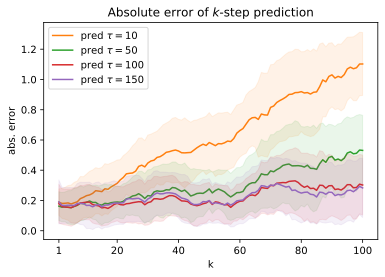

In [13]:
# Plot forecasts
k = 100
t0_range = range(600, 620+1)
errors = { tau:[] for tau in tau_range }
fig, ax = plt.subplots()

for i, tau in enumerate(tau_range):
    kstep_model = ForecastModel(tau=tau, data=noisy_data, cutoff=cutoff)  
    for t0 in t0_range:
        actual = noisy_data.query(f't in {[t0+k for k in range(1, k+1)]}').x
        preds = kstep_model.predict(t=t0, k=k)
        errors[tau].append(np.abs(preds - actual).values)

    errors[tau] = pd.DataFrame(errors[tau])
    x = range(1, k+1)
    y = errors[tau].describe().loc['mean']
    σ = errors[tau].describe().loc['std']
    yp = y + σ
    yn = y - σ
    plt.fill_between(x, yp, yn, color=f'C{i+1}', zorder=3+i, alpha=0.1)
    ax.plot(x, y, color=f'C{i+1}', zorder=3+i, label=r'pred $\tau = $' + f'{tau}')


plt.legend()
plt.xlabel('k')
plt.ylabel(f'abs. error')
plt.xticks([1, 20, 40, 60, 80, 100])
plt.title(r'Absolute error of $k$-step prediction');

Here absolute error curves are averaged for $k$-step predictions over prediction points $t \in [600, 620].$ Note that there seems to be little gain in going from $\tau = 100$ to $\tau = 150$.

## Text data to sequences

We will often work with text data represented as sequences of words or characters. In this section, we look at basic tools for converting raw text into sequences of the appropriate form. A typical preprocessing pipeline has the following steps:

1. Load text as strings into memory.
2. Split the strings into tokens (e.g., words or characters).
3. Build a vocabulary which maps each element to a numerical index.
4. Convert the text into sequences of numerical indices using the mapping.

In [14]:
!wget http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt -O ./data/timemachine.txt

--2022-08-06 00:17:56--  http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt
Resolving d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)... 54.192.19.52
Connecting to d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)|54.192.19.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178979 (175K) [text/plain]
Saving to: ‘./data/timemachine.txt’

./data/timemachine. 100%[===================>] 174.78K   562KB/s    in 0.3s    

2022-08-06 00:17:57 (562 KB/s) - ‘./data/timemachine.txt’ saved [178979/178979]



In [15]:
class TimeMachine:

    def __init__(self):
        """H.G. Wells' Time Machine."""

    def _download(self):
        os.system(f'wget http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt -O {DATASET_DIR}/timemachine.txt')
        fname = f'{DATASET_DIR}/timemachine.txt'
        with open(fname) as f:
            return f.read()

    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()

    def tokenize_words(self, text):
        return text.split()

    def tokenize_chars(self, text):
        return list(text)


data = TimeMachine()
raw_text = data._download()
raw_text[:60]


--2022-08-06 00:17:57--  http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt
Resolving d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)... 54.192.19.52
Connecting to d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)|54.192.19.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178979 (175K) [text/plain]
Saving to: ‘/Users/particle1331/code/inefficient-networks/docs/notebooks/tensorflow/data/timemachine.txt’

     0K .......... .......... .......... .......... .......... 28%  647K 0s
    50K .......... .......... .......... .......... .......... 57%  434K 0s
   100K .......... .......... .......... .......... .......... 85% 1.38M 0s
   150K .......... .......... ....                            100% 1.65M=0.2s

2022-08-06 00:17:58 (721 KB/s) - ‘/Users/particle1331/code/inefficient-networks/docs/notebooks/tensorflow/data/timemachine.txt’ saved [178979/178979]



'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [16]:
text = data._preprocess(raw_text)

print('Raw:', repr(raw_text[:60]))
print('Preprocessed:', repr(text[:60]))

Raw: 'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'
Preprocessed: 'the time machine by h g wells i the time traveller for so it'


### Tokenization

Tokens are atomic units of text. What precisely is a token is a design choice. For example, we can reduce sentences into words where the set of words comprise a large vocabulary. Or we can reduce a sentence into characters where the vocabulary contains only 256 ASCII characters. This is shown below:

In [17]:
print(','.join(data.tokenize_chars(text)[:30]))
print(','.join(data.tokenize_words(text)[:30]))

t,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, 
the,time,machine,by,h,g,wells,i,the,time,traveller,for,so,it,will,be,convenient,to,speak,of,him,was,expounding,a,recondite,matter,to,us,his,grey


### Constructing vocabularies

A **vocabulary** is simply a mapping from tokens to a unique index. First, we determine the set of unique tokens in our training **corpus** which are mapped to a numerical index. Rare vocabulary elements can be dropped without sacrificing performance. Tokens that had not been previously seen or was dropped from the vocabulary is represented by a special `<unk>` token.

In [18]:
class Vocab:    
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        """Vocabulary for text."""
        
        # Count token frequencies; sort decreasing based on counts
        counter = collections.Counter(tokens)
        self.token_freqs_ = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        
        # The list of unique tokens sorted alphabetically
        self._idx_to_token = list(
            sorted(
                ['<unk>'] \
                + reserved_tokens \
                + [token for token, freq in self.token_freqs_ if freq >= min_freq]
            )
        )
        
        # Inverse mapping
        self._token_to_idx = { 
            token: idx for idx, token in enumerate(self._idx_to_token)
        }

    @property
    def unk_idx(self):
        """Index for the unknown token."""
        return self._token_to_idx['<unk>']

    def __len__(self):
        return len(self._idx_to_token)


    def __getitem__(self, tokens):
        """Convert token (/tokens) to index (/index list)."""

        if not isinstance(tokens, (list, tuple)):
            return self._token_to_idx.get(tokens, self.unk_idx)
        
        return [self.__getitem__(token) for token in tokens]


    def to_tokens(self, indices):
        """Convert index (/indices) to token (/token list)."""

        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self._idx_to_token[int(index)] for index in indices]
        
        return self._idx_to_token[indices]

Let's construct a vocabulary of words in the text. This keeps a frequency count:

In [19]:
vocab = Vocab(
    tokens=data.tokenize_words(text),
    min_freq=10,
    reserved_tokens=[]
)

print(vocab.token_freqs_[:5])
print(vocab.token_freqs_[-5:])

[('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816)]
[('cheerlessly', 1), ('advancement', 1), ('makers', 1), ('casual', 1), ('brittle', 1)]


Converting indices to tokens:

In [20]:
print(vocab.to_tokens(0))
print(vocab.to_tokens([0, 1, 2, 3]))

<unk>
['<unk>', 'a', 'about', 'above']


Converting tokens to indices:

In [21]:
print(vocab['123@#@33X'])
print(vocab['1231??XXX', 'above', 'about', 'a'])

0
[0, 3, 2, 1]


Size of the vocabulary:

In [22]:
len(vocab)

400